# This notebook is to evaluate quality of module extraction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from scipy.stats import ttest_ind
from sklearn.metrics import normalized_mutual_info_score as nmi
from functions.subset_network import subset_network
from functions.graph_distance import *
from functions.network_embedding import *
from functions.process_phenotype import *
import matplotlib.pyplot as plt
%matplotlib inline

In [197]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Network community evaluation

## Evaluation 1: correlation between phenotypes and network modules

In [2]:
meta = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_coga.inia.detailed.pheno.04.12.17.csv')

In [3]:
expression = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_batch.age.rin.sex.pm.alc.corrected.coga.inia.expression.txt', sep = '\t')

In [5]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0) 

In [6]:
expression = expression[expression.id.isin(tom_df.index)]

In [7]:
expression_t = expression.T
expression_t.columns = expression_t.iloc[0,:]
expression_t.drop('id', inplace=True)

In [180]:
expression_meta = pd.merge(expression_t, meta, left_index = True, right_on = 'IID')

In [182]:
expression_meta.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\expression_meta.csv', index = 0)

In [183]:
expression_meta = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\expression_meta.csv', low_memory = False)

In [184]:
expression_meta.head()

,ENSG00000227232,ENSG00000237683,ENSG00000241860,ENSG00000228463,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,...,Agonal_phase,Liver_class,Smoking_frequency,Pack_yrs_1_pktperday_1_yr),AUDIT,alcohol_intake_gmsperday,Total_drinking_yrs,Depression,Anxiety,SR
0,3.133118,3.823457,1.022690,4.174664,4.721111,6.249569,10.326613,5.613722,7.627960,6.452445,...,Rapid,Steatosis,99 - Not reported,NaN,186.0,266.0,23.0,Yes,No,1
1,2.389945,1.997970,0.368830,3.233721,5.096691,7.036703,11.125171,5.548298,7.972209,6.557081,...,Rapid,Normal,99 - Not reported,NaN,NaN,NaN,NaN,No,No,2
2,1.877375,2.878354,0.028265,3.250095,4.613348,6.347241,10.051990,5.206124,7.612012,6.188654,...,Rapid,Normal,01 - Everyday/7days per week,42.0,42.0,102.0,27.0,Yes,No,3
3,2.657129,1.632495,0.247083,4.155158,5.912895,7.480004,11.234187,6.384119,8.501137,6.789110,...,Intermediate,Steatosis,99 - Not reported,NaN,0.0,0.0,NaN,No,No,4
4,3.186562,3.185500,1.100501,2.999840,5.616984,7.564768,10.804071,6.327458,8.428120,7.109489,...,Rapid,Normal,01 - Everyday/7days per week,38.0,56.0,136.0,31.0,Yes,No,5


## Evaluation 1a: Find variable genes between phenotype groups. Use Alc_status as the control since it was used to calculate DE.

#### Use t-test to compare between the alcoholic group and the control group. It only works when they're two groups. For multiple groups or groups with continuous values (such as AUDIT), we need other methods to get those "variable genes". I haven't figured out the method yet. 

In [15]:
variable_genes = []
for col in expression_meta.columns[:19911]:
    ttest = ttest_ind(expression_meta[expression_meta.Alc_status == 'Alcoholic'][col], expression_meta[expression_meta.Alc_status == 'Control'][col])
    if ttest[1] < 0.5:
        variable_genes.append(col)

In [17]:
# collect up genes if the mean is higher in alcoholic than control
up_genes = []
for gene in variable_genes:
    alc = expression_meta[expression_meta.Alc_status == 'Alcoholic'][gene]
    control = expression_meta[expression_meta.Alc_status == 'Control'][gene]
    if np.mean(alc) > np.mean(control):
        up_genes.append(gene)

In [18]:
down_genes = []
for gene in variable_genes:
    alc = expression_meta[expression_meta.Alc_status == 'Alcoholic'][gene]
    control = expression_meta[expression_meta.Alc_status == 'Control'][gene]
    if np.mean(alc) < np.mean(control):
        down_genes.append(gene)

In [12]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [11]:
community_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_louvain_default.csv')

### Use NMI to determine how well the network community labels correlate with the alcohol phenotypes. The idea is up_genes belong to 1 cluster and down_genes belong to another cluster. 

In [13]:
def nmi_features_genes_n_community(gene_sets, community = community_df):
    community_id = []
    gene_set_id = []
    for i, g_set in enumerate(gene_sets):
        community_id += community_df[community_df['id'].isin(g_set)]['louvain_label'].tolist()
        gene_set_id += [i]*len(g_set)
    return nmi(community_id, gene_set_id)

In [33]:
# up_genes and down_genes each as a cluster 
nmi_both = nmi_features_genes_n_community([up_genes, down_genes])

In [34]:
# up_genes as a cluster only
nmi_up = nmi_features_genes_n_community([up_genes])

In [35]:
# down_genes as a cluster only
nmi_down = nmi_features_genes_n_community([down_genes])

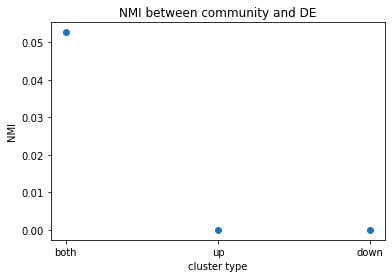

In [38]:
plt.scatter(['both','up', 'down'], [nmi_both, nmi_up, nmi_down])
plt.xlabel('cluster type')
plt.ylabel('NMI')
plt.title('NMI between community and DE');

## Evaluation 1b.1: Measure percentage of genes in a module that are significantly variable for specific traits

### What percentage of genes are significantly different between AUDIT groups as determined by ANOVA?

In [186]:
# get the expression of the patients grouped by AUDIT score with AUDIT = nan removed
audit_subset = get_expression_by_audit()

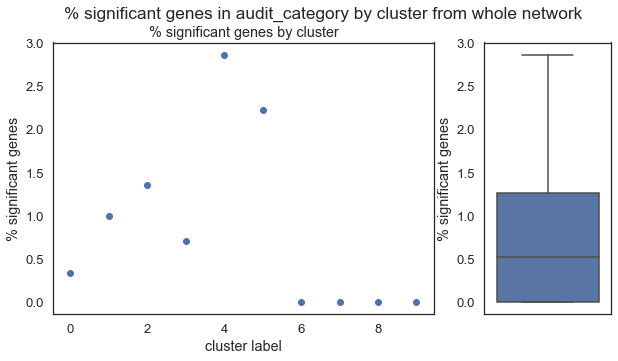

In [227]:
# correlation between audit phenotype and communities in the network 
plot_sig_perc(audit_subset, community_df, 'louvain_label', 'audit_category', 'whole network')

## Evaluation 1b.2: Measure correlation between alcohol phenotypes and genes in a module

In [229]:
clusters = community_df.louvain_label.unique()

In [230]:
clusters

array([1, 2, 5, 6, 0, 4, 3, 7, 8, 9], dtype=int64)

In [232]:
cluster_genes = community_df[community_df['louvain_label'] == 0]['id'].tolist()

In [233]:
cluster_expression = expression_meta[cluster_genes].apply(pd.to_numeric)

In [234]:
cluster_expression.head()

,ENSG00000198744,ENSG00000230092,ENSG00000242485,ENSG00000130764,ENSG00000116251,ENSG00000116237,ENSG00000171735,ENSG00000116288,ENSG00000074800,ENSG00000178585,...,ENSG00000259886,ENSG00000147382,ENSG00000130826,ENSG00000130830,ENSG00000185010,ENSG00000165775,ENSG00000185515,ENSG00000155959,ENSG00000155961,ENSG00000185973
0,6.452445,1.499930,3.582519,4.691260,5.173800,5.035511,7.377895,5.487850,7.740650,4.480257,...,2.081143,2.909727,3.317048,4.285629,3.727926,3.924684,3.965173,4.193218,3.900806,3.515112
1,6.557081,1.666303,4.179962,4.846680,5.475937,5.352853,7.658507,5.755284,8.112731,4.970886,...,1.965378,3.223087,3.538084,4.471721,3.943266,4.295238,4.029042,5.181479,4.468532,4.153872
2,6.188654,1.269383,3.584667,4.531916,5.309618,5.091317,7.604663,5.217658,7.471598,4.066255,...,2.145258,2.437704,3.397413,4.154442,3.711236,3.888803,4.361965,4.357797,4.268276,3.686998
3,6.789110,-0.223799,4.232277,4.870110,5.476582,5.418161,7.690072,5.979137,8.154138,4.590394,...,2.483583,3.225396,3.373203,4.862100,3.635812,4.145646,4.034311,4.355968,4.092267,3.164490
4,7.109489,0.642573,4.186185,4.985434,5.426040,5.354697,7.682186,5.992522,8.193155,4.766406,...,2.314255,3.412337,3.472381,4.568243,3.593314,4.231189,3.873386,4.617065,4.185462,3.746089


In [349]:
4**2/9**2

0.19753086419753085

In [350]:
del pca_cluster_expression, pca

In [354]:
from sklearn.decomposition import PCA

def cluster_phenotype_corr(expression_meta_df, cluster_df, cluster_column, network_name):
    clusters = cluster_df[cluster_column].unique()
    i = 1
    for cluster in clusters:
        cluster_genes = cluster_df[cluster_df[cluster_column] == cluster]['id'].tolist() 
        cluster_expression = expression_meta_df[cluster_genes].apply(pd.to_numeric)
        pca = PCA(n_components = 1)
        pca_cluster_expression = pca.fit_transform(cluster_expression)
        eigen_n_features = pd.DataFrame({'eigen':pca_cluster_expression.reshape(len(pca_cluster_expression),),
                                         'BMI':expression_meta['BMI'], 'RIN':expression_meta['RIN'], 
                                         'Age':expression_meta['Age'], 'PM!':expression_meta['PM!'], 
                                         'Brain_pH':expression_meta['Brain_pH'], 'Pack_yrs_1_pktperday_1_yr': expression_meta['Pack_yrs_1_pktperday_1_yr)'],
                                         'AUDIT': expression_meta['AUDIT'], 'alcohol_intake_gmsperday':expression_meta['alcohol_intake_gmsperday'],
                                         'Total_drinking_yrs': expression_meta['Total_drinking_yrs'], 'SR': expression_meta['SR']})
        
        if i == 1:
            clusters_corr = pd.DataFrame({cluster:eigen_n_features.corr()['eigen'][1:]})
            i += 1
        else:
            clusters_corr[cluster] = eigen_n_features.corr()['eigen'][1:]
    clusters_corr = clusters_corr.T
    
    sns.heatmap(clusters_corr.sort_index(), cmap = 'RdBu',
            vmin = -1, vmax = 1)
    plt.ylabel('cluster id')
    plt.title(f'Trait cluster correlation for {network_name}')

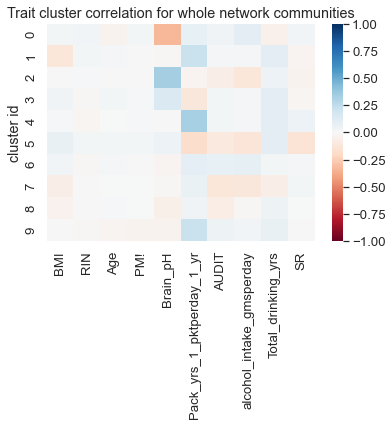

In [355]:
cluster_phenotype_corr(expression_meta, community_df, 'louvain_label', 'whole network communities')

# Embedding evaluation

## Evaluation 1: embedding cluster comparison

In [ ]:
# Different subnetwork will create different embedding. How will the clusters from these different embeddings compare?

In [ ]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0) 

In [140]:
subset_G = []
subset_df = []
for weight in [0.218, 0.24, 0.278]:
    subset, G = subset_network(tom_df, weight, 0.98)
    subset_df.append(subset)
    subset_G.append(G)
    emb_df = network_embedding(G, 16, 100, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data', weight)

Number of edges left: 10100.0


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


embedding data saved
Number of edges left: 4967.0


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s]


embedding data saved
Number of edges left: 1092.0


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.00it/s]


embedding data saved


### Evaluation 1a: compare subnetwork by graph distance

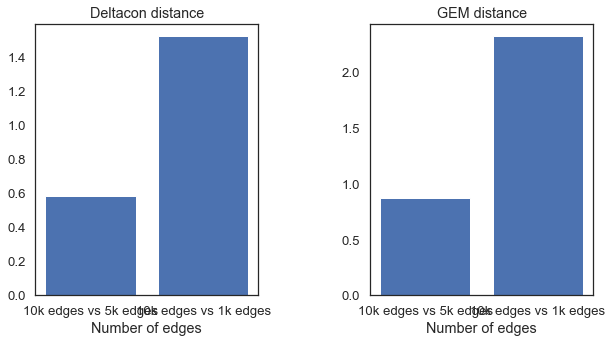

In [150]:
plot_graph_distance(subset_df, ['10k', '5k', '1k'])

### Evaluation 1b: compare embedding from subnetworks by comparing k mean clusters with jaccard and NMI

In [159]:
os.chdir(r'C:\Users\bbche\Documents\GitRepos\assist\data')
subset_kmeans = []
for file in ['embedded_len16_walk100_0.218.csv', 'embedded_len16_walk100_0.24.csv', 'embedded_len16_walk100_0.278.csv']:
    emb = pd.read_csv(file, index_col = 0)
    subset_kmeans.append(run_kmeans(emb, 10))

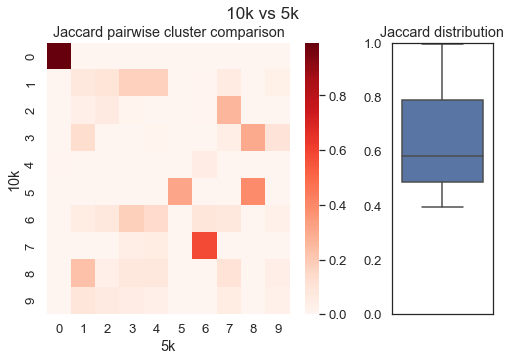

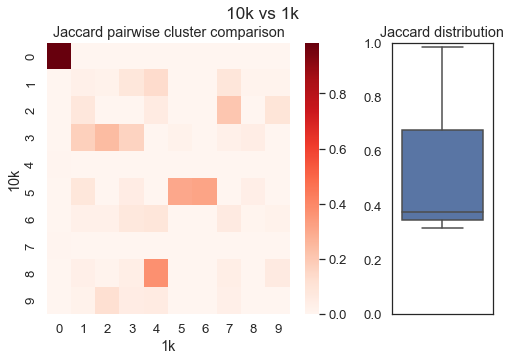

In [161]:
cluster_jaccard(subset_kmeans[0], subset_kmeans[1], 'kmean_label', ['10k','5k'], top = 3)
cluster_jaccard(subset_kmeans[0], subset_kmeans[2], 'kmean_label', ['10k','1k'], top = 3)

### Evaluation 1c: compare subnetwork by correlation to phenotype

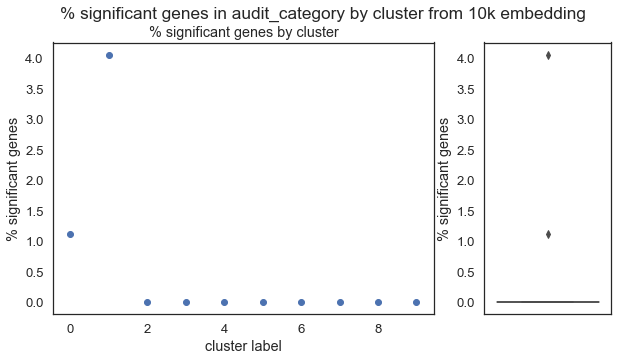

In [226]:
# Correlation between 10k embedding and AUDIT phenotype
plot_sig_perc(audit_subset, subset_kmeans[0], 'kmean_label', 'audit_category', '10k embedding')

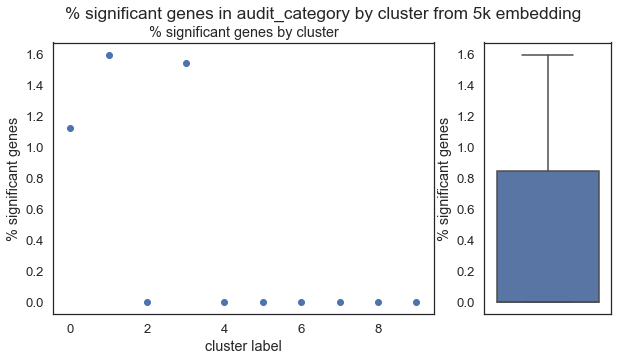

In [228]:
plot_sig_perc(audit_subset, subset_kmeans[1], 'kmean_label', 'audit_category', '5k embedding')

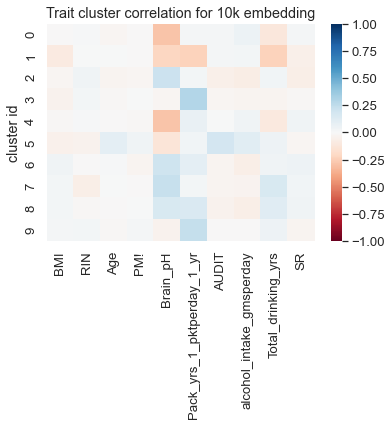

In [357]:
cluster_phenotype_corr(expression_meta, subset_kmeans[0], 'kmean_label', '10k embedding')

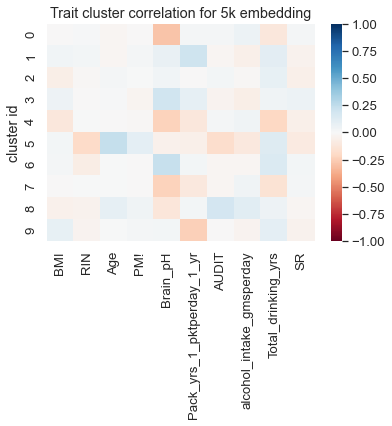

In [358]:
cluster_phenotype_corr(expression_meta, subset_kmeans[1], 'kmean_label', '5k embedding')

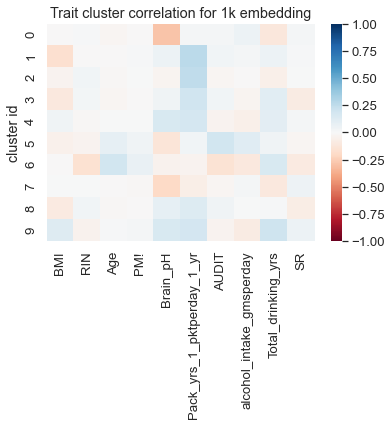

In [359]:
cluster_phenotype_corr(expression_meta, subset_kmeans[2], 'kmean_label', '1k embedding')